In [ ]:
# main.py

import polars as pl
import os

from src.futuapi.futu_api import FutuApi
from src.calculator.mathmatics import add_mean, add_boll

# 设置 Polars 显示的最大行数和列数
# pl.Config.set_tbl_width(1000)  # 设置表格的最大宽度，单位为字符
pl.Config.set_tbl_cols(100)  # 设置显示的最大列数
pl.Config.set_tbl_rows(10)  # 设置显示的最大行数


def parse_df_time(df):
    df = df.with_columns(
        pl.col("time_key").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S"),
        pl.col("close").cast(pl.Float64).alias("price"),
    )
    df = df.with_columns(
        [
            pl.col("time_key").dt.date().cast(pl.Utf8).alias("date"),
            pl.col("time_key").dt.time().cast(pl.Utf8).alias("time"),
        ]
    )
    return df


def trans(fund_df: pl.DataFrame, index_df: pl.DataFrame):
    fund_df = (
        parse_df_time(fund_df)
        .filter(pl.col("time") == "14:50:00")
        .select(["date", "price"])
    )
    # print(fund_df)

    index_df = parse_df_time(index_df)
    df_index_vol = (
        index_df.group_by("date")
        .agg([pl.col("volume").sum().alias("volume")])
        .sort("date")
    )
    df_index_check_vol = (
        index_df.filter(pl.col("time") <= "14:50:00")
        .group_by("date")
        .agg([pl.col("volume").sum().alias("check_volume")])
        .sort("date")
    )
    df_index_check_price = (
        index_df.filter(pl.col("time") == "14:50:00")
        .with_columns(pl.col("price").cast(pl.Float64).alias("check_index_price"))
        .select("date", "check_index_price")
    )

    df = (
        index_df.filter(pl.col("time") == "15:00:00")
        .with_columns(pl.col("price").cast(pl.Float64).alias("index_price"))
        .select("date", "index_price")
        .join(df_index_check_vol, on=["date"])
        .join(df_index_vol, on=["date"])
        .join(df_index_check_price, on=["date"])
        .join(fund_df, on=["date"])
    ).select(
        ["date", "check_volume", "volume", "check_index_price", "index_price", "price"]
    )
    df = df.sort("date")
    # print(index_df)
    df = df.with_columns(
        pl.col("index_price").shift(1).rolling_max(window_size=25).alias("max_25")
    )
    df = df.with_columns(
        pl.col("check_volume").shift(1).rolling_mean(window_size=10).cast(pl.Int64).alias("avg_vol_30")
    )

    # df = df.with_columns(pl.col("price").rolling_mean(5).alias(f"ma_5"))
    # df = df.with_columns(pl.col("price").rolling_mean(20).alias(f"ma_20"))
    # df = df.with_columns(pl.col("price").rolling_mean(60).alias(f"ma_60"))
    # df = df.with_columns(pl.col("price").rolling_mean(120).alias(f"ma_120"))

    # df = df.with_columns(
    #     pl.col("price").rolling_min(window_size=5, min_periods=1).alias("min_5")
    # )
    # df = df.with_columns([(pl.col("price") - pl.col("price").shift(5)).alias("del_10")])

    # print(df)

    return df


import time
from dataclasses import dataclass


@dataclass
class FundRecord:
    date: str
    price: float
    check_index_price: float
    index_price: float
    check_volume: int
    volume: int
    max_25: float
    avg_vol_30: int


api = FutuApi()
info = []
# code = "SH.510050" # 50
# index_code = "SH.000016"
# code = "SH.510300" # 300
# index_code = "SH.000300"
# code = "SH.512100" # 1000
# index_code = "SH.000852"
# code = "SH.510500" # 500
# index_code = "SH.000905"
code = "SH.512880" # 证券
index_code = "SZ.399975"
# code = "SH.512690" # 酒
# index_code = "SZ.399987"
# code = "SH.512800" # 银行
# index_code = "SZ.399986"
# code = "SZ.159915" # 创业板
# index_code = "SZ.399006"

try:
    fund_df = api.get_minute_kline(code, "2017-01-01", "2024-11-21")
    index_df = api.get_minute_kline(index_code, "2017-01-01", "2024-11-21")
    df = trans(fund_df, index_df)
    for row in df.iter_rows(named=True):
        # print(row)
        record = FundRecord(
            date=row["date"],
            price=row["price"],
            check_index_price=row["check_index_price"],
            index_price=row["index_price"],
            check_volume=row["check_volume"],
            volume=row["volume"],
            max_25=row["max_25"],
            avg_vol_30 = row['avg_vol_30'],
        )
        info.append(record)

    # print(info["2024-11-08"])
finally:
    api.close()

pl.Config.set_tbl_cols(100)
pl.Config.set_tbl_rows(100)
# pl.Config.set_tbl_cols(100)
df

: 

[2017-02-21] buy, val: 99900.11800000002, vol: 1115698089 1031800908.0 price: 1.074
[2017-02-22] sale, val: 99242.79400000001
[2017-06-19] buy, val: 99143.70760000001, vol: 1184893443 843463905.6 price: 1.008
[2017-06-27] sale, val: 100026.63820000002
[2017-07-10] buy, val: 99926.78880000004, vol: 1581190645 847425140.4 price: 1.022
[2017-07-14] sale, val: 101681.38310000002
[2017-07-19] buy, val: 101579.82500000003, vol: 2401664160 1318450562.3999999 price: 1.059
[2017-07-21] sale, val: 100807.63820000003
[2017-08-02] buy, val: 100706.93870000006, vol: 2494151942 1639016293.2 price: 1.077
[2017-08-07] sale, val: 99018.32870000006
[2017-08-28] buy, val: 98919.48050000008, vol: 4382985511 984542655.5999999 price: 1.122
[2017-09-04] sale, val: 99612.73940000006
[2018-01-17] buy, val: 99513.32580000008, vol: 2752442613 1051972239.5999999 price: 1.027
[2018-01-25] sale, val: 104829.29140000009
[2018-07-24] buy, val: 104724.62720000009, vol: 1330757837 636506562.0 price: 0.773
[2018-07-27] 

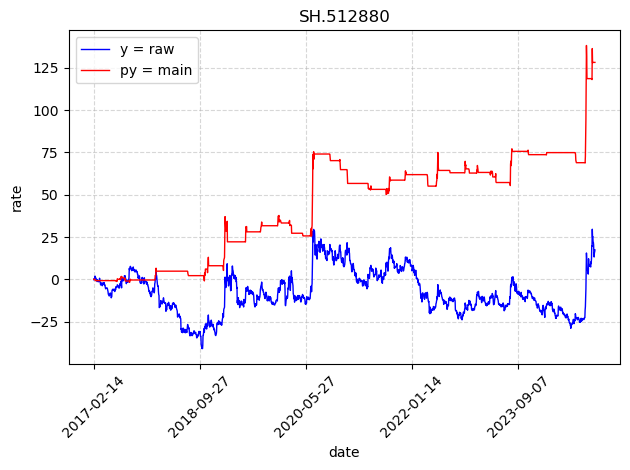

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def truncate_float(number, t):
    factor = 10.0**t
    truncated = math.trunc(number * factor) / factor
    return truncated


def show_rate(x: list, y: list, py: list):
    ax = plt.gca()  # 获取当前轴对象
    ax.xaxis.set_major_locator(
        MaxNLocator(integer=True, prune="both", nbins=6)
    )  # 自动选择6个关键点显示
    plt.plot(x, y, linestyle="-", linewidth=1, color="b", label="y = raw")
    plt.plot(x, py, linestyle="-", linewidth=1, color="r", label="py = main")
    plt.title(f"{code}")
    plt.xlabel("date")
    plt.ylabel("rate")
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.5)
    # 显示图例
    plt.legend()

    # 显示图形
    plt.show()


class Account:
    def __init__(self):
        # self.code = "SH.560050"
        self.cash = 100000
        self.position = 0
        self.fee = 0.001
        self.buys = []
        self.sales = []
        self.has_position = 0
        self.no_position = 0
        self.max_val = 0.0
        self.max_drawdone = 0.0
        self.rate = 0.0

    def val(self, price):
        return self.cash + self.position * price

    def buy(self, price):
        if self.position != 0:
            return
        price = price * (1.0 + self.fee)
        cnt = truncate_float(self.cash / price, -2)
        self.position += cnt
        self.cash -= cnt * price
        # print(f"buy: val: {self.val(price)}")
        self.buys.append(self.val(price))

    def sale(self, price):
        if self.position == 0:
            return
        price *= 1.0 - self.fee
        self.cash += self.position * price
        self.position = 0
        # print(f"sale: val: {self.val(price)}")
        self.sales.append(self.val(price))

    def get_rate(self, price) -> float:
        if self.position == 0:
            self.no_position += 1
        else:
            self.has_position += 1

        self.max_val = max(self.max_val, self.val(price))
        self.max_drawdone = max(
            self.max_drawdone, (self.max_val - self.val(price)) / self.max_val * 100
        )
        self.rate = (self.val(price) * 100 / 100000) - 100.0
        return self.rate

    def print(self):
        s_cnt = 0
        f_cnt = 0
        for i in range(0, len(self.sales)):
            if self.buys[i] < self.sales[i]:
                s_cnt += 1
            else:
                f_cnt += 1
        print(
            f"s_cnt: {s_cnt}, f_cnt: {f_cnt}, "
            f"has_position {self.has_position}, no_position: {self.no_position}, "
            f"max_drawdone:{self.max_drawdone}, rate: {self.rate}"
        )


account = Account()

less_20 = False
less_5 = False
greater_120 = False
init_price = 0.0

x = []
y = []
py = []
vol = []

last_price = 0.0
trade_cnt = 0

for record in info:
    if record.price == 0.0 or record.max_25 == None:
        continue
    if init_price == 0.0:
        init_price = record.price

    if (
        record.check_index_price >= record.max_25
        and record.check_volume > record.avg_vol_30 * 1.2
        and account.position == 0
    ):
        # if record.check_index_price >= record.max_25:
        account.buy(record.price)
        print(
            f"[{record.date}] buy, val: {account.val(record.price)}, "
            f"vol: {record.check_volume} {record.avg_vol_30 * 1.2} "
            f"price: {record.price}"
        )
    elif (
        record.check_index_price <= record.max_25 * 0.95
        or record.check_volume < record.avg_vol_30
    ) and account.position != 0:
        account.sale(record.price)
        print(f"[{record.date}] sale, val: {account.val(record.price)}")
    # less_20 = record.price <= record.ma_20
    # less_5 = record.price <= record.ma_5
    # greater_120 = record.price > record.ma_120

    ac_rate = account.get_rate(record.price)
    # print(ac_rate, record.price * 100 / init_price - 100.0)
    x.append(record.date)
    y.append(record.price * 100 / init_price - 100.0)
    py.append(ac_rate)
    # time.sleep(1)

    # print(account.rate(record.price), record.price * 100 / init_price - 100.0)


# print(trade_cnt)
account.print()


show_rate(x, y, py)